In [8]:
#Importar librerías principales
import os, sys
import pandas as pd
import joblib
import importlib

#Ajustar path para importar desde src (subir un nivel desde notebooks/)
sys.path.append(os.path.abspath(os.path.join("..", "src")))

#Importar módulos propios
import evaluate   # importa el módulo entero
from data_loader import cargar_dataset, dividir_dataset
from preprocessing import preparar_texto, preparar_labels, vectorizar_texto
from train import baseline_train, guardar_modelo
from utils import semilla
from evaluate import evaluar_modelo
#Configuración
semilla(42)

#Recargar el módulo evaluate (por si editamos evaluate.py)
importlib.reload(evaluate)

<module 'evaluate' from 'c:\\Users\\kevin\\OneDrive\\Escritorio\\Biomedical-Classification-Challenge\\biomedical-classification\\src\\evaluate.py'>

In [9]:
#Cargar dataset preparado
df = pd.read_csv("../data/dataset_prepared.csv", sep=",")
print("Tamaño del dataset:", df.shape)
df.head()

Tamaño del dataset: (3565, 5)


,title,abstract,group,text,labels_list
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal,Adrenoleukodystrophy: survey of 303 cases: bio...,"['neurological', 'hepatorenal']"
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological,endoscopy reveals ventricular tachycardia secr...,['neurological']
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal,dementia and cholecystitis: organ interplay Pu...,['hepatorenal']
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological,The interpeduncular nucleus regulates nicotine...,['neurological']
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,neurological,guillain-barre syndrome pathways in leukemia H...,['neurological']


In [10]:
#Dividir en train/val/test (estratificado)
train_df, val_df, test_df = dividir_dataset(df, test_size=0.2, val_size=0.1, random_state=42)
len(train_df), len(val_df), len(test_df)

(2566, 286, 713)

In [11]:
#Preparar textos
X_train_text = preparar_texto(train_df)
X_val_text   = preparar_texto(val_df)
X_test_text  = preparar_texto(test_df)

In [12]:
#Preparar etiquetas (multilabel)
y_train, mlb = preparar_labels(train_df)
y_val  = mlb.transform(val_df["group"].apply(lambda x: x.split("|")))
y_test = mlb.transform(test_df["group"].apply(lambda x: x.split("|")))

print("Clases detectadas:", mlb.classes_)
print("Shape de etiquetas de entrenamiento:", y_train.shape)

Clases detectadas: ['cardiovascular' 'hepatorenal' 'neurological' 'oncological']
Shape de etiquetas de entrenamiento: (2566, 4)


In [13]:
#Vectorizar textos (TF-IDF)
X_train, vectorizer = vectorizar_texto(X_train_text, max_features=5000)
X_val  = vectorizer.transform(X_val_text)
X_test = vectorizer.transform(X_test_text)

In [14]:
#Entrenar modelo baseline (One-vs-Rest con Regresión Logística)
modelo = baseline_train(X_train, y_train)

c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



--- Resultados baseline (val) ---
Exact Match Ratio: 0.6399
F1 Micro: 0.8006
F1 Macro: 0.7342

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.99      0.72      0.83       102
   hepatorenal       1.00      0.53      0.69        87
  neurological       0.85      0.94      0.89       142
   oncological       1.00      0.35      0.52        48

     micro avg       0.92      0.71      0.80       379
     macro avg       0.96      0.63      0.73       379
  weighted avg       0.94      0.71      0.78       379
   samples avg       0.89      0.78      0.81       379



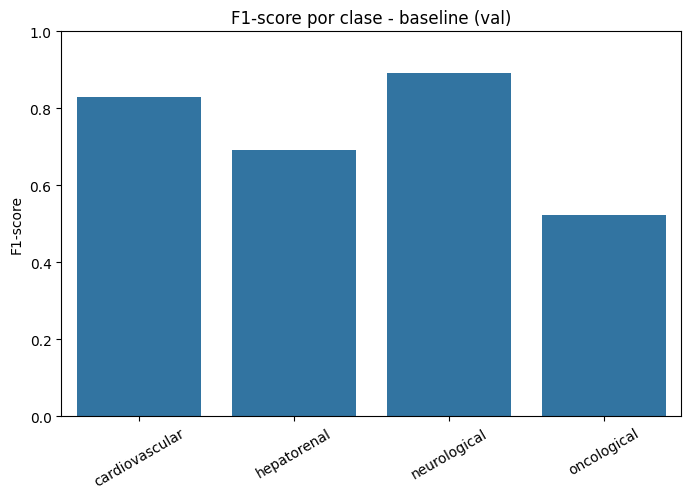

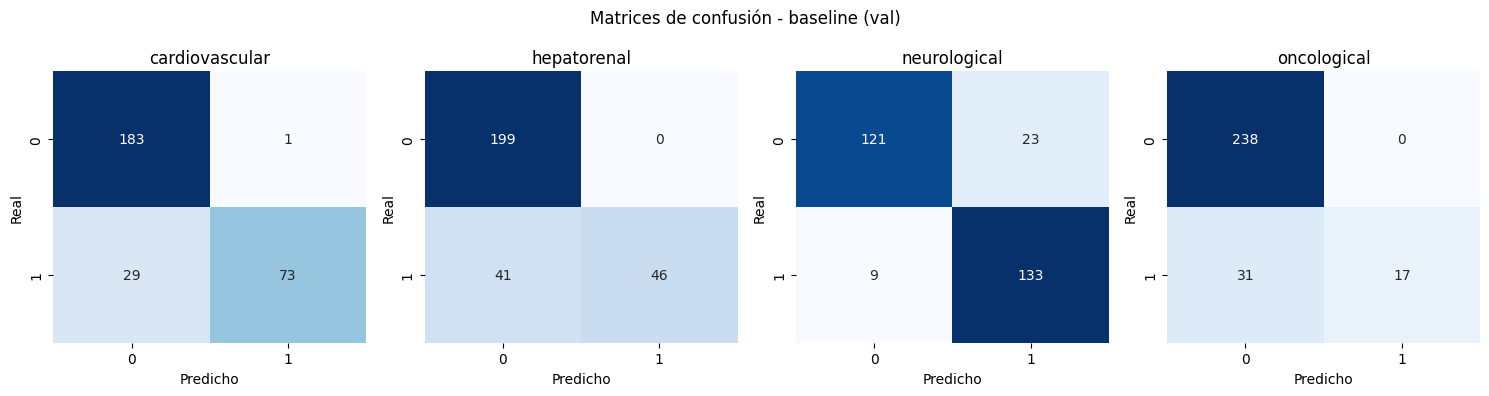

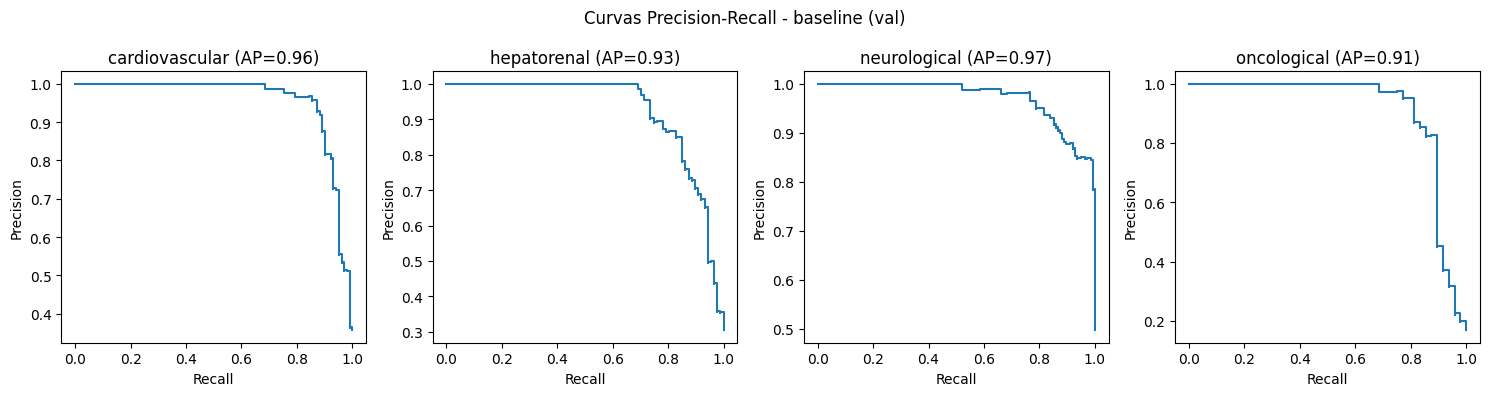

In [15]:
#Evaluación en validación guardando evidencia
metrics_val = evaluar_modelo(
    modelo,
    X_val,
    y_val,
    mlb,
    nombre_modelo="baseline",
    split="val",
    show_plots=True,
    save_path="../evidence/baseline_val"
)

In [16]:
#Guardar modelo, vectorizador y binarizador
guardar_modelo(modelo, "../models/baseline_ovr_logreg.joblib") 
joblib.dump(vectorizer, "../models/tfidf_vectorizer.joblib") 
joblib.dump(mlb, "../models/labels_mlb.joblib") 

['../models/labels_mlb.joblib']

c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



--- Resultados baseline (test) ---
Exact Match Ratio: 0.6550
F1 Micro: 0.8116
F1 Macro: 0.7663

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.98      0.71      0.82       254
   hepatorenal       0.99      0.57      0.73       217
  neurological       0.87      0.91      0.89       358
   oncological       1.00      0.46      0.63       120

     micro avg       0.93      0.72      0.81       949
     macro avg       0.96      0.66      0.77       949
  weighted avg       0.94      0.72      0.80       949
   samples avg       0.89      0.79      0.82       949



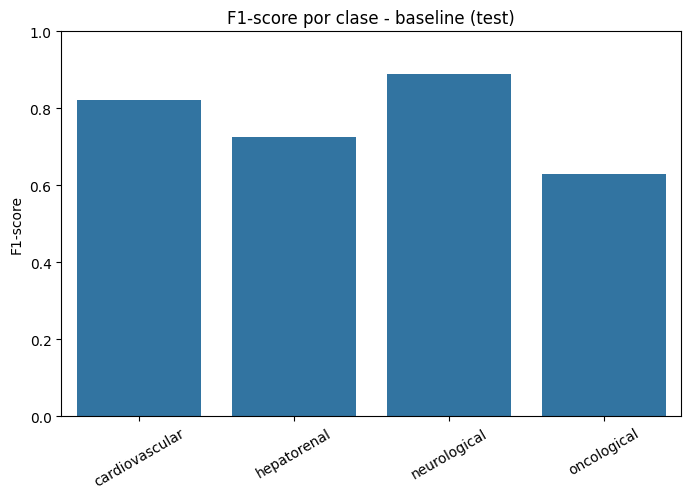

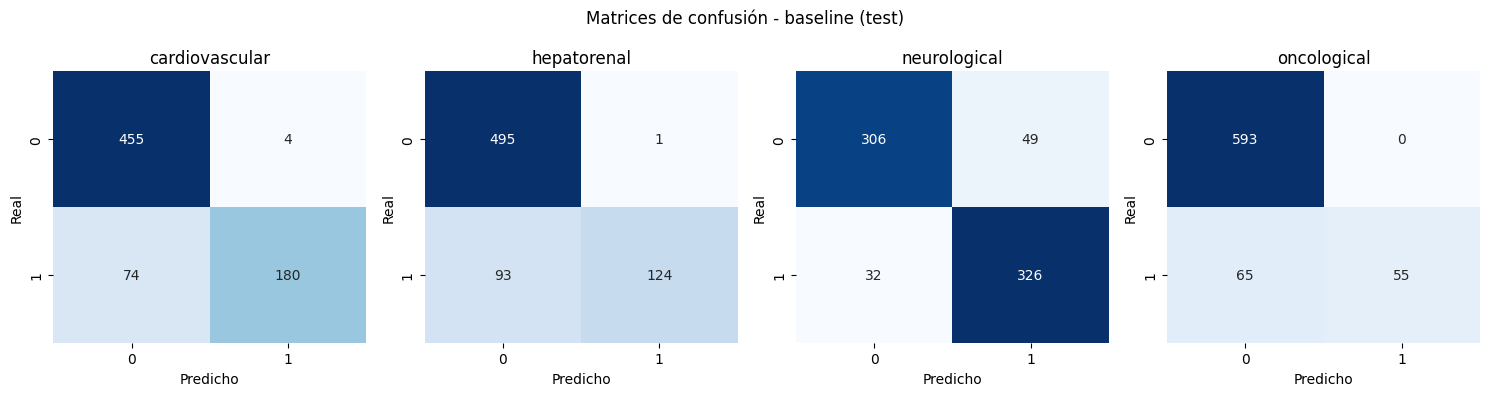

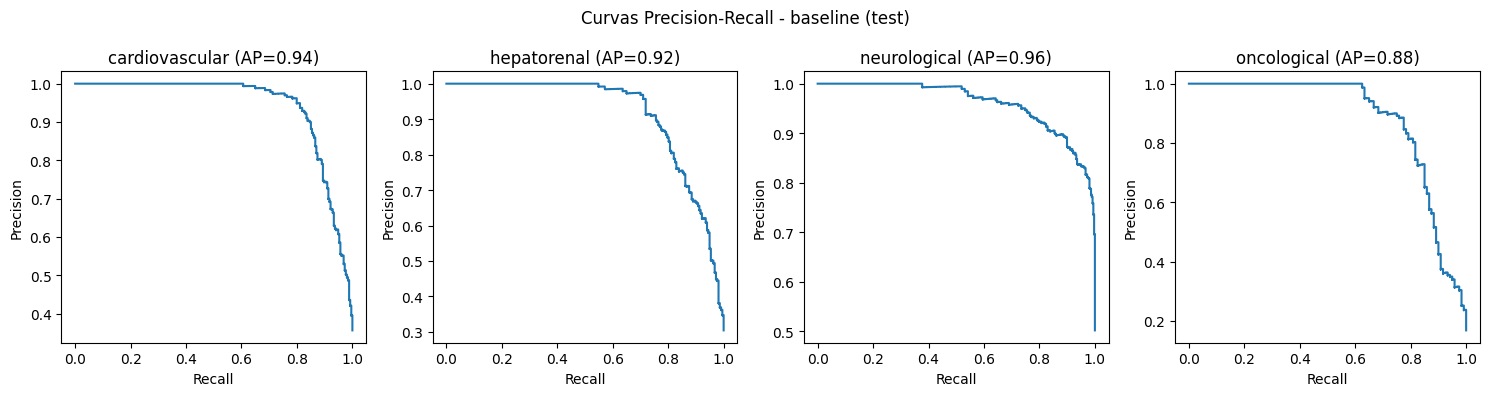

In [17]:
#Evaluación en prueba guardando evidencia
metrics_test = evaluar_modelo(
    modelo,
    X_test,
    y_test,
    mlb,
    nombre_modelo="baseline",
    split="test",
    show_plots=True,
    save_path="../evidence/baseline_test"
)